In [1]:
using StatsPlots, DelimitedFiles, CSV, Plots, DataFrames, DifferentialEquations

In [2]:
# reading a delimited file
I = readdlm("US_exchanges_2018c.csv")

15×15 Array{Float64,2}:
 1.28153    0.0135159  0.00773    …  0.0156276  0.0094602  0.0146184
 0.0372335  1.11834    0.093211      0.0151296  0.0138087  0.0268551
 0.0184729  0.0166119  1.04222       0.021795   0.008112   0.0099787
 0.0120597  0.012506   0.0193105     0.0076677  0.0087455  0.0287984
 0.387082   0.236255   0.134891      0.1598     0.159384   0.223719 
 0.150443   0.0526213  0.03145    …  0.0374893  0.0335185  0.0431247
 0.0083378  0.0036551  0.0075759     0.0077494  0.012921   0.0033437
 0.0681456  0.0521195  0.0750681     0.0267532  0.0229341  0.0362094
 0.0195425  0.0257214  0.0222736     0.0384731  0.0409086  0.0452146
 0.186783   0.136408   0.0748774     0.165861   0.157982   0.0864993
 0.0992767  0.169228   0.114341   …  0.194094   0.129072   0.126296 
 0.0005429  0.0003333  0.0007803     0.0017449  0.0048802  0.0079003
 0.0088715  0.0086924  0.0105185     1.03519    0.0162784  0.0114603
 0.0092786  0.0070565  0.0051895     0.0163076  1.01573    0.0135882
 0.0222345

In [3]:
employed = CSV.read("LA_employment_by_sector_2020.csv")

,Sector,Jan,Feb,Mar,Apr,Jan_Feb,Feb_Mar
,String,Int64,Int64,Int64,Int64,Float64,Float64
1,Total farm,37600,36600,34400,41000,0.000265957,0.000601093
2,Mining and logging,300,300,300,200,0.0,0.0
3,Utilities,4300,2300,2800,2500,0.00465116,-0.00217391
4,Construction,18200,18300,18300,18200,-5.49451e-5,0.0
5,Manufacturing,25900,26100,26000,24100,-7.72201e-5,3.83142e-5
6,Wholesale trade,14600,14800,14700,13500,-0.000136986,6.75676e-5
7,Retail trade,39300,38800,38400,32200,0.000127226,0.000103093
8,Transportation and warehousing,14500,14300,14400,12700,0.000137931,-6.99301e-5
9,Information,3400,3400,3400,3000,0.0,0.0


In [4]:
no_sectors = size(I,1)

# beta and gamma matrices
A = Array{Float64}(undef,no_sectors,no_sectors)
B = Array{Float64}(undef,no_sectors,no_sectors)
C = Array{Float64}(undef,no_sectors,no_sectors)
abc = Float64[]
for i = 1:no_sectors
    row_sum = 0.0
    for j = 1:no_sectors
        row_sum = row_sum +I[i,j] + I[j,i]
    end
    row_sum = row_sum - I[i,i]
    push!(abc,row_sum)
end
#print(abc)

        
for i = 1:no_sectors
    #abc = sum(I[:,1])+sum(I[1,:])-(I[1,1])
    for j = 1:no_sectors
        A[i,j] = 0.0
        B[i,j] = I[j,i]/abc[i]
        C[i,j] = I[i,j]/abc[i]
    end
    A[i,i] = I[i,i]/abc[i]
    B[i,i] = 0.0
    C[i,i] = 0.0
end
#print(B)

In [5]:
function sir_ode2(du,u,p,t)
    s,i,r = u
    R = p
    du[1] = -R*s*i
    du[2] = R*s*i-i
    du[3] = i
end

sir_ode2 (generic function with 1 method)

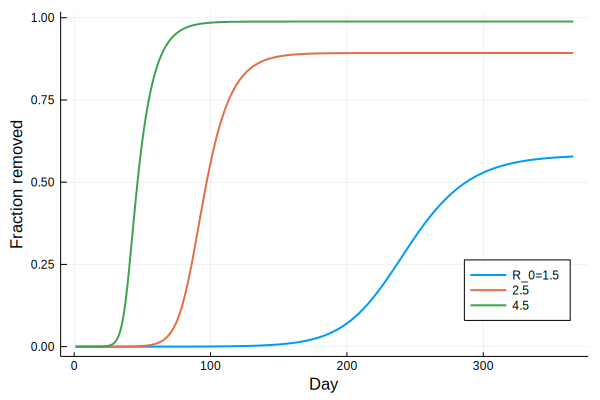

In [6]:
# run SIR ODEs
sols = Array{Float64}(undef,36,366)
tally = [1]
for i = 1:35
    
    parms = 1.0+(i*0.1)
    init = [0.999998,0.000002,0.0]
    tspan = (0.0,365.0)
    sir_prob1 = ODEProblem(sir_ode2,init,tspan,parms)
    sir_sol1 = solve(sir_prob1,saveat = 0.1)
    sol = Array(sir_sol1)
    
    for k = 1:366
        sols[tally[1],k] = sol[3,k]
    end
    tally[1] = tally[1] + 1
    
end
# example plots
plot(sols[5,:],xlabel="Day",ylabel="Fraction removed",label="R_0=1.5",leg=:bottomright,lw=2)
plot!(sols[15,:],lw=2,label="2.5")
plot!(sols[35,:],lw=2,label="4.5")

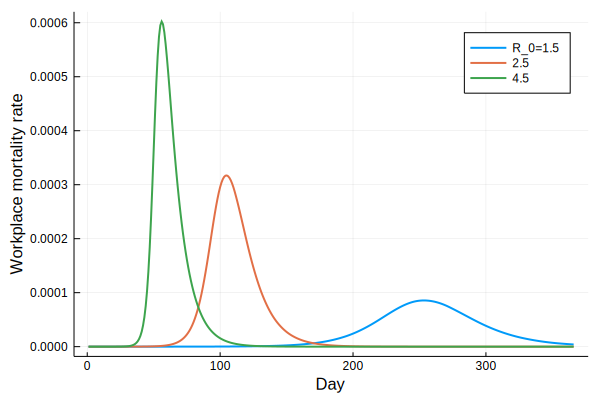

In [7]:
# calculate daily mortalities
d = Array{Float64}(undef,36,366)
for j = 1:36
    R_0 = sols[j,:]
    d[j,1] = 0.0
    for i = 2:size(R_0,1)
        if i>14
            #push!(d,0.03*0.453*(R_0[i-13]-R_0[i-14]))
            d[j,i] = 0.03*0.453*(R_0[i-13]-R_0[i-14])
        else
            #push!(d,0.0)
            d[j,i] = 0.0
        end
    end
end
plot(d[5,:],label="R_0=1.5",xlabel="Day",ylabel="Workplace mortality rate",lw=2)
plot!(d[15,:],lw=2,label="2.5")
plot!(d[35,:],lw=2,label="4.5")

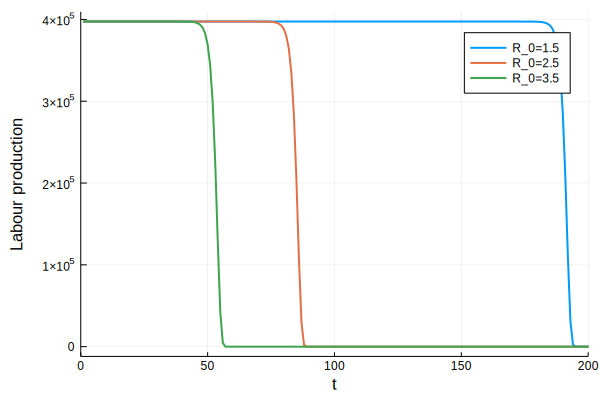

In [8]:
# time
T = 365

ep = Array{Float64}(undef,35,T)
ep2 = Array{Float64}(undef,T*35,3)

tally1 = Array{Int64}(undef,1)
tally1[1] = 1

for l = 1:35
    # parameter array
    # add column vector for time
    p = Array{Float64}(undef,T,no_sectors,3)
    for i = 1:T
        #p[i,no_sectors+1] = i
        for j = 1:no_sectors
            p[i,j,1] = 0.0
            if i==1
            p[i,j,2] = 0.0
            elseif i>1
            p[i,j,2] = -1.0*d[l,i]
            end
            p[i,j,3] = 0.0
        end
    end
    #print(p)

    # perturbation
    D = Array{Float64}(undef,T,no_sectors)
    for i = 1:T
        for j = 1:no_sectors
            D[i,j] = p[i,j,1]+p[i,j,2]+p[i,j,3]
        end
    end
    #print(D)

    # employment
    Ep = Array{Float64}(undef,T,no_sectors+1)
    Up = Array{Float64}(undef,T,no_sectors+1)
    # initial conditions
    for i = 1:T
        Ep[i,1] = convert(Float64,i)
        Up[i,1] = convert(Float64,i)
        for j = 1:no_sectors
            Ep[i,j+1] = 0.0
            Up[i,j+1] = 0.0
        end
    end
    for i = 1:no_sectors
        Ep[1,1] = 1.0
        Ep[1,i+1] = employed[i,:Mar]
        Up[1,1] = 1.0
        Up[1,i+1] = 0.0
    end

    # simulate
    for i = 2:T
        Ep[i,1] = convert(Float64,i)
        for j = 1:no_sectors
            alpha = A[j,j]*(1.0+D[i,j])*Ep[i-1,j+1]/Ep[1,j+1]
            #println(alpha)
            beta = 0.0
            for k = 1:no_sectors
                beta = beta + ((1.0+D[i,k])*(B[j,k]+C[j,k])*(Ep[i-1,k+1]/Ep[1,k+1]))
            end
            #println(beta)
            a = alpha+beta
            #println(a)
            # modify E and U
            if a-1.0 >= 0.0 # positive growth
                del_E = round(a*(Ep[i-1,j+1]) - Ep[i-1,j+1])
                #println(i," ",del_E)
                if del_E <= Up[i-1,j+1] # if re-hiring possible
                    Ep[i,j+1] = round(a*Ep[i-1,j+1]) #+ del_E
                    Up[i,j+1] = round((Up[i-1,j+1]*(1-p[2])) + ((Ep[i-1,j+1]-Ep[i,j+1])))*(1-p[2])
                elseif del_E > Up[i-1,j+1]
                    Ep[i,j+1] = Ep[i-1,j+1] + Up[i-1,j+1]
                    Up[i,j+1] = 0.0
                end
            elseif a-1.0 < 0.0 # negative growth
                del_E = Ep[i-1,j+1] - round(a*(Ep[i-1,j+1]))
                #println(i," ",del_E)
                Ep[i,j+1] = round(a*(Ep[i-1,j+1]))
                Up[i,j+1] = round(Up[i-1,j+1]*(1-p[2]) + (Ep[i-1,j+1]-Ep[i,j+1]))
            end
            # no negative unemployment
            if Up[i,j+1] < 0.0
                Up[i,j+1] = 0.0
            end
            if Up[i,j+1] >= Ep[1,j+1]
                Up[i,j+1] = Ep[1,j+1]
            end
        end
    end
    #print(E)

    # export
    for i = 1:T
        ep[l,i] = sum(Ep[i,:])-Ep[i,1]
        ep2[tally1[1],1] = convert(Float64,i)
        ep2[tally1[1],2] = 1.0+(l*0.1)
        ep2[tally1[1],3] = ep[l,i]
        tally1[1] = tally1[1] + 1
    end
end
    
plot(ep[5,:],xlabel="t",ylabel="Labour production",label="R_0=1.5",lw=2,xlims=(0.0,200.0))
#plot!(up,label="basic press model",lw=2)
#plot(p[:,:,2])
plot!(ep[15,:],lw=2,label="R_0=2.5")
plot!(ep[35,:],lw=2,label="R_0=3.5")

In [9]:
writedlm("Fresno_bote1.csv",ep2)